<a id='home'></a>
### Contents

[Imports](#Imports)

[Dataloading](#Dataloading)

[DrawingGraph](#DrawingGraph)

<a id='Imports'></a>
### Imports
[back to contents](#home)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join as p_join
import sys
import itertools
from collections import Counter
from datetime import datetime, date, timedelta
from typing import List, Tuple, Dict, Set, Any, Optional, Callable
from pathlib import Path
sys.path.insert(0, str(Path(os.getcwd()).parent))
import requests
import json
import pickle
from tqdm import tqdm
try:
    from fabulous import color as fb_color
    color_print = lambda x, color='green': print(getattr(fb_color, color)(x)) if 'fb_color' in globals() else print(x)
except Exception as e:
    color_print = lambda x, color='green': print(x)

from bs4 import BeautifulSoup
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import networkx as nx
from yfiles_jupyter_graphs import GraphWidget

# import ipycytoscape
# from ipycytoscape import CytoscapeWidget

In [3]:
pd.set_option('display.max_columns', 200)

In [4]:
matplotlib.rcParams['figure.figsize'] = (7, 7)
sns.set_style('whitegrid')

In [5]:
# from src.common_utils import get_container_ipaddr
# from src.minio_utils import initialize_minio_client, load_json_from_minio
from src.db_utils import get_pg_engine
from src.common_utils import (
    prepare_date,
    clip_categories,
    choose_fighter_stats,
    get_ego_graph,
)

<a id='Dataloading'></a>
### Dataloading
[back to contents](#home)

In [6]:
eng = get_pg_engine()

df = pd.read_sql('select * from raw_data.all_fights_info', eng)
print(f'df: {df.shape[0]:,} x {df.shape[1]:,}')
df.head(3)

df: 7,582 x 165


,fighter1__names,fighter2__names,fight_name,method,round,time,timeformat,referee,date,location,event_name,event_uri,fight_uri,fighter1__winloose,fighter2__winloose,fighter1__per_round_stats__round1__fighter,fighter2__per_round_stats__round1__fighter,fighter1__per_round_stats__round1__kd,fighter2__per_round_stats__round1__kd,fighter1__per_round_stats__round1__sig_str,fighter2__per_round_stats__round1__sig_str,fighter1__per_round_stats__round1__sig_str_perc,fighter2__per_round_stats__round1__sig_str_perc,fighter1__per_round_stats__round1__totalstr,fighter2__per_round_stats__round1__totalstr,fighter1__per_round_stats__round1__td_perc,fighter2__per_round_stats__round1__td_perc,fighter1__per_round_stats__round1__sub_att,fighter2__per_round_stats__round1__sub_att,fighter1__per_round_stats__round1__rev,fighter2__per_round_stats__round1__rev,fighter1__per_round_stats__round1__ctrl,fighter2__per_round_stats__round1__ctrl,fighter1__per_round_stats__round1__head,fighter2__per_round_stats__round1__head,fighter1__per_round_stats__round1__body,fighter2__per_round_stats__round1__body,fighter1__per_round_stats__round1__leg,fighter2__per_round_stats__round1__leg,fighter1__per_round_stats__round1__distance,fighter2__per_round_stats__round1__distance,fighter1__per_round_stats__round1__clinch,fighter2__per_round_stats__round1__clinch,fighter1__per_round_stats__round1__ground,fighter2__per_round_stats__round1__ground,fighter1__per_round_stats__round2__fighter,fighter2__per_round_stats__round2__fighter,fighter1__per_round_stats__round2__kd,fighter2__per_round_stats__round2__kd,fighter1__per_round_stats__round2__sig_str,fighter2__per_round_stats__round2__sig_str,fighter1__per_round_stats__round2__sig_str_perc,fighter2__per_round_stats__round2__sig_str_perc,fighter1__per_round_stats__round2__totalstr,fighter2__per_round_stats__round2__totalstr,fighter1__per_round_stats__round2__td_perc,fighter2__per_round_stats__round2__td_perc,fighter1__per_round_stats__round2__sub_att,fighter2__per_round_stats__round2__sub_att,fighter1__per_round_stats__round2__rev,fighter2__per_round_stats__round2__rev,fighter1__per_round_stats__round2__ctrl,fighter2__per_round_stats__round2__ctrl,fighter1__per_round_stats__round2__head,fighter2__per_round_stats__round2__head,fighter1__per_round_stats__round2__body,fighter2__per_round_stats__round2__body,fighter1__per_round_stats__round2__leg,fighter2__per_round_stats__round2__leg,fighter1__per_round_stats__round2__distance,fighter2__per_round_stats__round2__distance,fighter1__per_round_stats__round2__clinch,fighter2__per_round_stats__round2__clinch,fighter1__per_round_stats__round2__ground,fighter2__per_round_stats__round2__ground,fighter1__per_round_stats__round3__fighter,fighter2__per_round_stats__round3__fighter,fighter1__per_round_stats__round3__kd,fighter2__per_round_stats__round3__kd,fighter1__per_round_stats__round3__sig_str,fighter2__per_round_stats__round3__sig_str,fighter1__per_round_stats__round3__sig_str_perc,fighter2__per_round_stats__round3__sig_str_perc,fighter1__per_round_stats__round3__totalstr,fighter2__per_round_stats__round3__totalstr,fighter1__per_round_stats__round3__td_perc,fighter2__per_round_stats__round3__td_perc,fighter1__per_round_stats__round3__sub_att,fighter2__per_round_stats__round3__sub_att,fighter1__per_round_stats__round3__rev,fighter2__per_round_stats__round3__rev,fighter1__per_round_stats__round3__ctrl,fighter2__per_round_stats__round3__ctrl,fighter1__per_round_stats__round3__head,fighter2__per_round_stats__round3__head,fighter1__per_round_stats__round3__body,fighter2__per_round_stats__round3__body,fighter1__per_round_stats__round3__leg,fighter2__per_round_stats__round3__leg,fighter1__per_round_stats__round3__distance,fighter2__per_round_stats__round3__distance,fighter1__per_round_stats__round3__clinch,fighter2__per_round_stats__round3__clinch,fighter1__per_round_stats__round3__ground,fighter2__per_round_stats__round3__ground,fighter1__per_round_stats__round4__fighter,fighter2__per_round_stats

In [7]:
df['date_processed'] = prepare_date(date_col=df['date'])
df['date_year_month'] = df['date_processed'].dt.to_period('M')

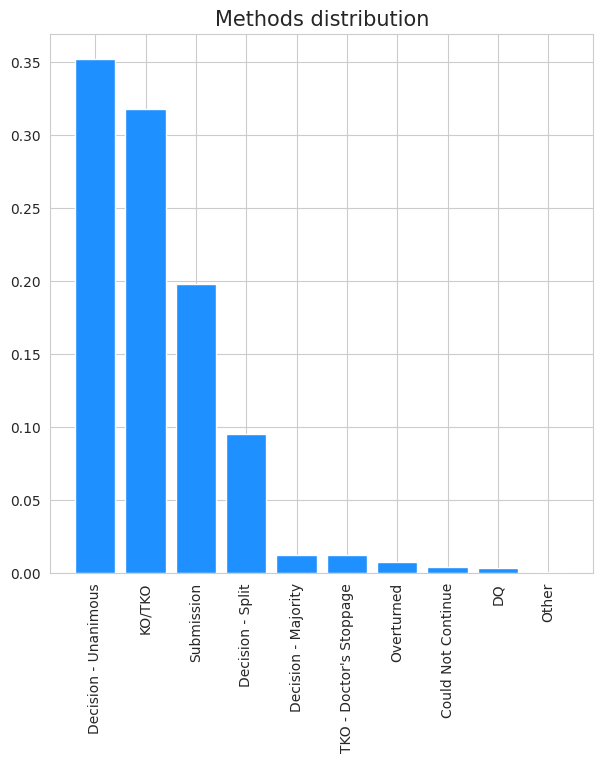

In [8]:
tmp = df['method'].value_counts(1).to_dict()
plt.title('Methods distribution', fontsize=15);
plt.bar(list(tmp.keys()), list(tmp.values()), color='dodgerblue');
plt.tick_params(axis='x', rotation=90);

In [9]:
from src.common_utils import clip_categories

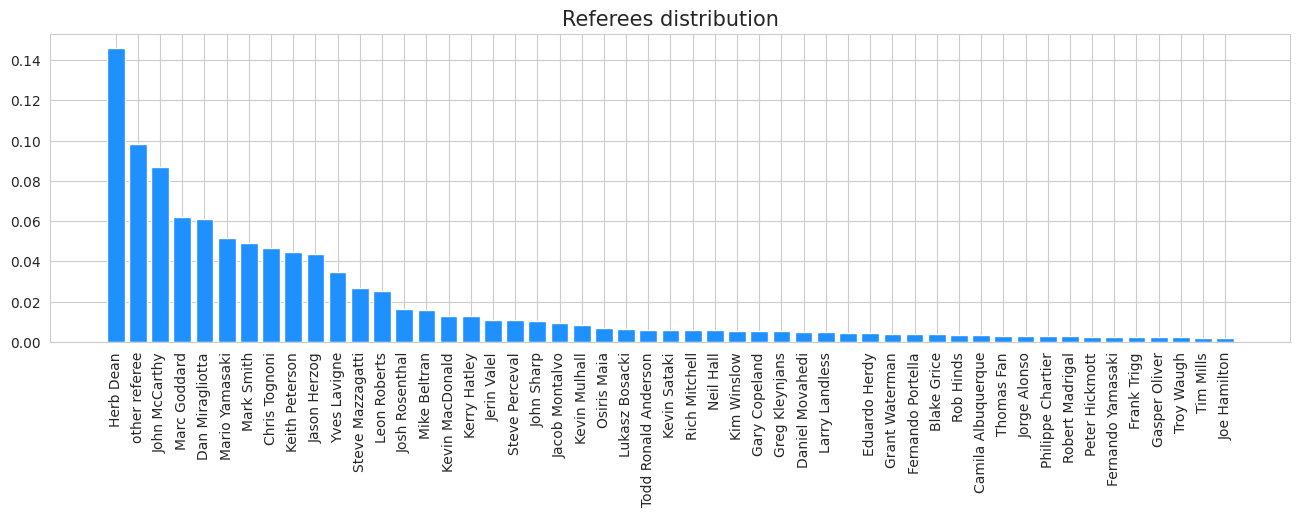

In [10]:
tmp = clip_categories(
    series=df['referee'],
    leave_top_n_categories=50,
    other_category_name='other referee'
)
tmp = tmp.value_counts(1).to_dict()
plt.figure(figsize=(16, 4))
plt.title('Referees distribution', fontsize=15);
plt.bar(list(tmp.keys()), list(tmp.values()), color='dodgerblue');
plt.tick_params(axis='x', rotation=90);

In [11]:
d = datetime.date(df['date_processed'][0])
d
# datetime.date(d.year, d.month // 3 + 1, 1)

datetime.date(2023, 2, 25)

In [15]:
tmp = pd.concat([
    df[['fighter1__names', 'fighter1__winloose']]
    .rename(columns={"fighter1__names": "names", "fighter1__winloose": 'winloose'}),
    df[['fighter2__names', 'fighter2__winloose']]
    .rename(columns={"fighter2__names": "names", "fighter2__winloose": 'winloose'})
], axis=0)

tmp = (
    tmp
    .assign(winloose_integer = lambda x: x['winloose'].map({'W':1, 'L': 0, 'D': 0, 'NC': 0}))
    .groupby(['names'])
    .agg(
        cnt = pd.NamedAgg(column='winloose_integer', aggfunc=lambda x: len(x)),
        sum_wins = pd.NamedAgg(column='winloose_integer', aggfunc=lambda x: sum(x)),
    )
    .reset_index()
    .sort_values(by=['cnt'], ascending=False)
)
tmp

,names,cnt,sum_wins
1117,Jim Miller,43,26
133,Andrei Arlovski,41,23
669,Donald Cerrone,38,23
461,Clay Guida,36,18
1909,Rafael Dos Anjos,35,21
...,...,...,...
1408,Kristian Rothaermel,1,0
1409,Kristof Midoux,1,0
1444,Lee Murray,1,1
1445,Leigh Remedios,1,0


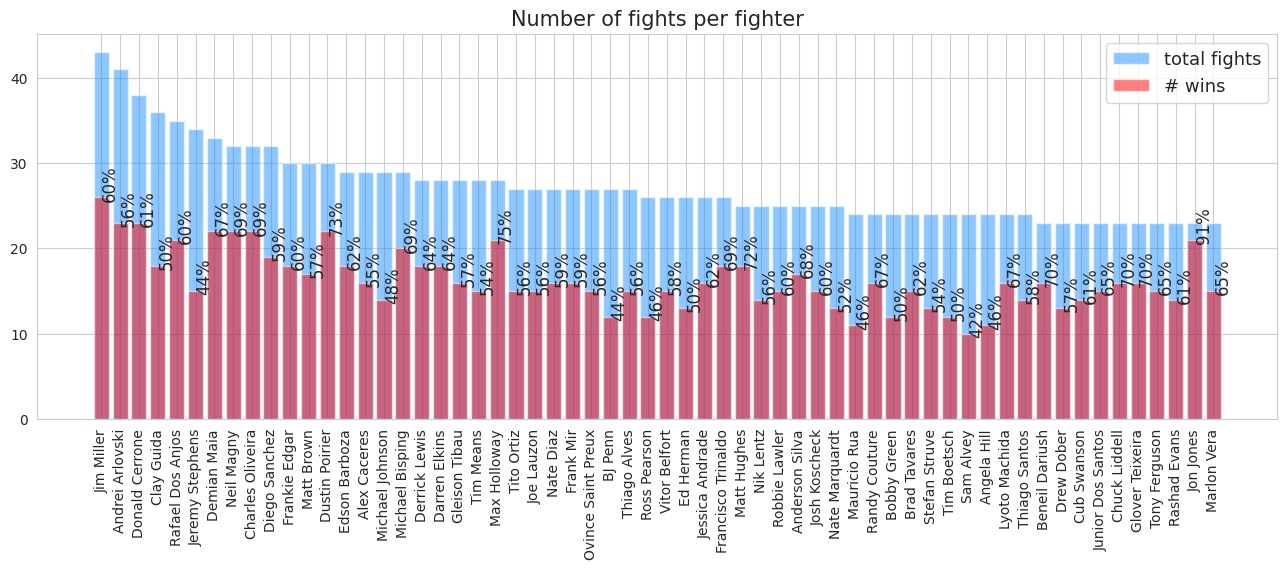

In [12]:
top_k = 60
tmp = pd.concat([
    df[['fighter1__names', 'fighter1__winloose']]
    .rename(columns={"fighter1__names": "names", "fighter1__winloose": 'winloose'}),
    df[['fighter2__names', 'fighter2__winloose']]
    .rename(columns={"fighter2__names": "names", "fighter2__winloose": 'winloose'})
], axis=0)

tmp = (
    tmp
    .assign(winloose_integer = lambda x: x['winloose'].map({'W':1, 'L': 0, 'D': 0, 'NC': 0}))
    .groupby(['names'])
    .agg(
        cnt = pd.NamedAgg(column='winloose_integer', aggfunc=lambda x: len(x)),
        sum_wins = pd.NamedAgg(column='winloose_integer', aggfunc=lambda x: sum(x)),
    )
    .reset_index()
    .assign(wins_fraction = lambda x: x['sum_wins'] / x['cnt'])
    .sort_values(by=['cnt'], ascending=False)
    .head(top_k)
)

plt.figure(figsize=(16, 5))
plt.title('Number of fights per fighter', fontsize=15);
plt.bar(tmp['names'].values[:top_k], tmp['cnt'].values[:top_k], color='dodgerblue', alpha=0.5, label='total fights')
plt.bar(tmp['names'].values[:top_k], tmp['sum_wins'].values[:top_k], color='red', alpha=0.5, label='# wins')
for name, sum_wins, wins_fraction in tmp[['names', 'sum_wins', 'wins_fraction']].itertuples(index=False):
    plt.text(name, sum_wins, f"{round(wins_fraction*100)}%", size=12, rotation=90);
plt.legend(fontsize=13);
plt.tick_params(axis='x', rotation=90)

In [14]:
[col.replace('fighter1__', '') for col in df.columns if col.startswith('fighter1__')]

['names',
 'winloose',
 'per_round_stats__round1__fighter',
 'per_round_stats__round1__kd',
 'per_round_stats__round1__sig_str',
 'per_round_stats__round1__sig_str_perc',
 'per_round_stats__round1__totalstr',
 'per_round_stats__round1__td_perc',
 'per_round_stats__round1__sub_att',
 'per_round_stats__round1__rev',
 'per_round_stats__round1__ctrl',
 'per_round_stats__round1__head',
 'per_round_stats__round1__body',
 'per_round_stats__round1__leg',
 'per_round_stats__round1__distance',
 'per_round_stats__round1__clinch',
 'per_round_stats__round1__ground',
 'per_round_stats__round2__fighter',
 'per_round_stats__round2__kd',
 'per_round_stats__round2__sig_str',
 'per_round_stats__round2__sig_str_perc',
 'per_round_stats__round2__totalstr',
 'per_round_stats__round2__td_perc',
 'per_round_stats__round2__sub_att',
 'per_round_stats__round2__rev',
 'per_round_stats__round2__ctrl',
 'per_round_stats__round2__head',
 'per_round_stats__round2__body',
 'per_round_stats__round2__leg',
 'per_round

In [73]:
pd.read_sql(
    """
    with union_df as (
        select
            fighter1__names as fighter
            , fighter1__winloose as winloose
            , cast(date as date)
        from 
            raw_data.all_fights_info
        
        union all

        select
            fighter2__names as fighter
            , fighter2__winloose as winloose
            , cast(date as date)
        from 
            raw_data.all_fights_info
    )

    select
        fighter
        , date
        , winloose
        , sum(cast(winloose = 'W' as integer)) over (partition by fighter order by date asc) as number_of_wins_so_far
        , row_number() over (partition by fighter order by date asc) as number_of_fights_so_far
    from
        union_df
    where
        fighter in (
            'Max Holloway',
            'Khabib Nurmagomedov'
        )
    order by
        fighter
        , date desc
    """,
    eng
)

,fighter,date,winloose,number_of_wins_so_far,number_of_fights_so_far
0,Khabib Nurmagomedov,2020-10-24,W,13,13
1,Khabib Nurmagomedov,2019-09-07,W,12,12
2,Khabib Nurmagomedov,2018-10-06,W,11,11
3,Khabib Nurmagomedov,2018-04-07,W,10,10
4,Khabib Nurmagomedov,2017-12-30,W,9,9
5,Khabib Nurmagomedov,2016-11-12,W,8,8
6,Khabib Nurmagomedov,2016-04-16,W,7,7
7,Khabib Nurmagomedov,2014-04-19,W,6,6
8,Khabib Nurmagomedov,2013-09-21,W,5,5
9,Khabib Nurmagomedov,2013-05-25,W,4,4


In [16]:
single_columns = ['method', 'round', 'date_processed']
needed_cols = [
    'names', 
    'winloose', 
    'per_round_stats__round1__sig_str', 
    'per_round_stats__round1__sig_str_perc',
    'per_round_stats__round1__totalstr',
    'per_round_stats__round1__td_perc',
    'per_round_stats__round1__sub_att',
    'per_round_stats__round1__rev',
    'per_round_stats__round1__ctrl',
    'per_round_stats__round1__head',
    'per_round_stats__round1__body',
    'per_round_stats__round1__leg',
    'per_round_stats__round1__distance',
    'per_round_stats__round1__clinch',
    'per_round_stats__round1__ground'
]
tmp_df = pd.concat([
    df[['fighter1__' + col for col in needed_cols] + single_columns]
    .rename(columns={'fighter1__' + col: col for col in needed_cols}),
    df[['fighter2__' + col for col in needed_cols] + single_columns]
    .rename(columns={'fighter2__' + col: col for col in needed_cols}),
], axis=0).sort_values(by=['date_processed'], ascending=True).reset_index(drop=True)
tmp_df

,names,winloose,per_round_stats__round1__sig_str,per_round_stats__round1__sig_str_perc,per_round_stats__round1__totalstr,per_round_stats__round1__td_perc,per_round_stats__round1__sub_att,per_round_stats__round1__rev,per_round_stats__round1__ctrl,per_round_stats__round1__head,per_round_stats__round1__body,per_round_stats__round1__leg,per_round_stats__round1__distance,per_round_stats__round1__clinch,per_round_stats__round1__ground,method,round,date_processed
0,Remco Pardoel,W,7 of 7,100%,7 of 7,100%,0,0,--,7 of 7,0 of 0,0 of 0,0 of 0,0 of 0,7 of 7,KO/TKO,1,1994-03-11
1,Johnny Rhodes,L,4 of 9,44%,4 of 9,---,0,0,--,2 of 5,0 of 0,2 of 4,4 of 9,0 of 0,0 of 0,Submission,1,1994-03-11
2,Jason DeLucia,L,0 of 0,---,0 of 0,100%,0,0,--,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,Submission,1,1994-03-11
3,Orlando Wiet,L,1 of 2,50%,5 of 7,---,0,0,--,0 of 1,0 of 0,1 of 1,1 of 2,0 of 0,0 of 0,KO/TKO,1,1994-03-11
4,Fred Ettish,L,4 of 7,57%,7 of 11,---,0,0,--,0 of 1,2 of 4,2 of 2,4 of 7,0 of 0,0 of 0,Submission,1,1994-03-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15159,Karl Williams,W,12 of 16,75%,35 of 51,100%,0,0,3:58,7 of 11,2 of 2,3 of 3,6 of 7,3 of 3,3 of 6,Decision - Unanimous,3,2024-03-23
15160,Amanda Ribas,L,16 of 47,34%,30 of 63,66%,0,0,0:18,8 of 33,2 of 6,6 of 8,14 of 45,2 of 2,0 of 0,Decision - Unanimous,5,2024-03-23
15161,Fernando Padilla,W,34 of 61,55%,35 of 64,---,1,0,0:47,24 of 49,6 of 8,4 of 4,17 of 32,0 of 0,17 of 29,Submission,1,2024-03-23
15162,Luis Pajuelo,L,5 of 13,38%,7 of 15,---,0,0,0:00,1 of 9,2 of 2,2 of 2,5 of 13,0 of 0,0 of 0,Submission,1,2024-03-23


In [101]:
def make_features(
    df: pd.DataFrame,
    name_col: str='names',
    date_col: str='date_processed',
) -> pd.DataFrame:
    
    for col in [name_col, date_col]:
        assert col in df.columns, f'{col} should be in df! But {df.columns} are the only columns in df!' 

    for col in ['winloose', 'method']:
        assert col in df.columns, f'{col} should be in df!'

    tmp = df.copy(deep=True)
    tmp = (
        df
        .sort_values(by=[name_col, date_col], ascending=False)
        .reset_index(drop=True)
    )
    tmp['n_fights_so_far'] = (
        tmp
        .assign(winloose_int = lambda x: x['winloose'].map({'W': 1}).fillna(0))
        .groupby([name_col])
        ['winloose_int']
        .transform(lambda x: x.sort_index(ascending=False).expanding().count().shift(1))
    )
    for winloose_status in ['W', 'L']:
        win_or_lose = 'wins' if winloose_status == 'W' else 'lost' if winloose_status == 'L' else ''
        tmp[f'n_{win_or_lose}_so_far'] = (
            tmp
            .assign(winloose_int = lambda x: x['winloose'].map({winloose_status: 1}).fillna(0))
            .groupby([name_col])
            ['winloose_int']
            .transform(lambda x: x.sort_index(ascending=False).expanding().sum().shift(1))
        )
        if 'n_fights_so_far' in tmp.columns:
            tmp[f'pers_{win_or_lose}_so_far'] = tmp[f'n_{win_or_lose}_so_far'] / tmp['n_fights_so_far']

    for winloose_status, method in itertools.product(['W', 'L'], tmp['method'].unique()):
        win_or_lose = 'wins' if winloose_status == 'W' else 'lost' if winloose_status == 'L' else ''
        method_ = (
            method
            .lower()
            .replace('-', '_')
            .replace(' ', '_')
            .replace('/', '_')
            .replace('__', '_')
            .replace("'s", "")
        )
        feature_name = f'n_{method_}_{win_or_lose}_so_far'.replace('__', '_')
        tmp[feature_name] = (
            tmp
            .assign(
                winloose_and_method = lambda x: 
                x['winloose'].map({winloose_status: 1}).fillna(0)
                * x['method'].map({method: 1}).fillna(0)
            )
            .groupby([name_col])
            ['winloose_and_method']
            .transform(
                lambda x: x.sort_index(ascending=False).expanding().sum().shift(1)
            )
        )
        if 'n_fights_so_far' in tmp.columns:
            tmp[feature_name.replace('n_', 'pers_')] = tmp[feature_name] / tmp['n_fights_so_far']
    
    for winloose_status in ['W', "L"]:
        win_or_lose = 'wins' if winloose_status == 'W' else 'lost' if winloose_status == 'L' else ''
        tmp[f'n_any_type_decision_{win_or_lose}_so_far'] = (
            tmp
            .assign(
                winloose_and_method = lambda x: 
                x['winloose'].map({winloose_status: 1}).fillna(0)
                * x['method'].apply(lambda x: 'decision' in str(x).lower()).fillna(0)
            )
            .groupby([name_col])
            ['winloose_and_method']
            .transform(
                lambda x: x.sort_index(ascending=False).expanding().sum().shift(1)
            )
        )
        if 'n_fights_so_far' in tmp.columns:
            tmp[f'pers_any_type_decision_{win_or_lose}_so_far'] = tmp[f'n_any_type_decision_{win_or_lose}_so_far'] / tmp['n_fights_so_far']

    tmp['winloose_last_fight'] = (
        tmp
        .groupby([name_col])
        ['winloose']
        .transform(
            lambda x: x.sort_index(ascending=False).shift(1)
        )
    )
    tmp['days_since_last_fight'] = (
        tmp
        .groupby([name_col])
        [date_col]
        .transform(
            lambda x:
            (x.sort_index(ascending=False) - x.sort_index(ascending=False).shift(1)).dt.days
        )
    )
    if 'days_since_last_fight' in tmp.columns:
        for stat, stat_func in [
                ('min', np.min),
                ('avg', np.mean),
                ('std', np.std),
                ('max', np.max)
            ]:
            tmp[f'{stat}_days_between_fights'] = (
                tmp
                .groupby([name_col])
                ['days_since_last_fight']
                .transform(
                    lambda x: stat_func(x)
                )
            )
    return tmp


In [103]:
from src.modelling.features.compute_features import make_features
tmp = (
    tmp_df
    .loc[(tmp_df['names'] == 'Conor McGregor') | (tmp_df['names'] == 'Max Holloway')]
    [['names', 'date_processed', 'winloose', 'method']]
    .sort_values(by=['names', 'date_processed'], ascending=False)
    .reset_index(drop=True)
)
features_df = make_features(
    df=tmp
)
print(features_df.shape)
features_df

(42, 43)


,names,date_processed,winloose,method,n_fights_so_far,n_wins_so_far,pers_wins_so_far,n_lost_so_far,pers_lost_so_far,n_ko_tko_wins_so_far,pers_ko_tko_wins_so_far,n_decision_unanimous_wins_so_far,pers_decisiopers_unanimous_wins_so_far,n_decision_split_wins_so_far,pers_decisiopers_split_wins_so_far,n_tko_doctor_stoppage_wins_so_far,pers_tko_doctor_stoppage_wins_so_far,n_submission_wins_so_far,pers_submissiopers_wins_so_far,n_decision_majority_wins_so_far,pers_decisiopers_majority_wins_so_far,n_ko_tko_lost_so_far,pers_ko_tko_lost_so_far,n_decision_unanimous_lost_so_far,pers_decisiopers_unanimous_lost_so_far,n_decision_split_lost_so_far,pers_decisiopers_split_lost_so_far,n_tko_doctor_stoppage_lost_so_far,pers_tko_doctor_stoppage_lost_so_far,n_submission_lost_so_far,pers_submissiopers_lost_so_far,n_decision_majority_lost_so_far,pers_decisiopers_majority_lost_so_far,n_any_type_decision_wins_so_far,pers_any_type_decision_wins_so_far,n_any_type_decision_lost_so_far,pers_any_type_decision_lost_so_far,winloose_last_fight,days_since_last_fight,min_days_between_fights,avg_days_between_fights,std_days_between_fights,max_days_between_fights
0,Max Holloway,2023-08-26,W,KO/TKO,27.0,20.0,0.740741,7.0,0.259259,8.0,0.296296,8.0,0.296296,1.0,0.037037,1.0,0.037037,2.0,0.074074,0.0,0.000000,0.0,0.000000,4.0,0.148148,2.0,0.074074,0.0,0.0,1.0,0.037037,0.0,0.0,9.0,0.333333,6.0,0.222222,W,133.0,42.0,156.333333,72.928682,371.0
1,Max Holloway,2023-04-15,W,Decision - Unanimous,26.0,19.0,0.730769,7.0,0.269231,8.0,0.307692,7.0,0.269231,1.0,0.038462,1.0,0.038462,2.0,0.076923,0.0,0.000000,0.0,0.000000,4.0,0.153846,2.0,0.076923,0.0,0.0,1.0,0.038462,0.0,0.0,8.0,0.307692,6.0,0.230769,L,287.0,42.0,156.333333,72.928682,371.0
2,Max Holloway,2022-07-02,L,Decision - Unanimous,25.0,19.0,0.760000,6.0,0.240000,8.0,0.320000,7.0,0.280000,1.0,0.040000,1.0,0.040000,2.0,0.080000,0.0,0.000000,0.0,0.000000,3.0,0.120000,2.0,0.080000,0.0,0.0,1.0,0.040000,0.0,0.0,8.0,0.320000,5.0,0.200000,W,231.0,42.0,156.333333,72.928682,371.0
3,Max Holloway,2021-11-13,W,Decision - Unanimous,24.0,18.0,0.750000,6.0,0.250000,8.0,0.333333,6.0,0.250000,1.0,0.041667,1.0,0.041667,2.0,0.083333,0.0,0.000000,0.0,0.000000,3.0,0.125000,2.0,0.083333,0.0,0.0,1.0,0.041667,0.0,0.0,7.0,0.291667,5.0,0.208333,W,301.0,42.0,156.333333,72.928682,371.0
4,Max Holloway,2021-01-16,W,Decision - Unanimous,23.0,17.0,0.739130,6.0,0.260870,8.0,0.347826,5.0,0.217391,1.0,0.043478,1.0,0.043478,2.0,0.086957,0.0,0.000000,0.0,0.000000,3.0,0.130435,2.0,0.086957,0.0,0.0,1.0,0.043478,0.0,0.0,6.0,0.260870,5.0,0.217391,L,189.0,42.0,156.333333,72.928682,371.0
5,Max Holloway,2020-07-11,L,Decision - Split,22.0,17.0,0.772727,5.0,0.227273,8.0,0.363636,5.0,0.227273,1.0,0.045455,1.0,0.045455,2.0,0.090909,0.0,0.000000,0.0,0.000000,3.0,0.136364,1.0,0.045455,0.0,0.0,1.0,0.045455,0.0,0.0,6.0,0.272727,4.0,0.181818,L,210.0,42.0,156.333333,72.928682,371.0
6,Max Holloway,2019-12-14,L,Decision - Unanimous,21.0,17.0,0.809524,4.0,0.190476,8.0,0.380952,5.0,0.238095,1.0,0.047619,1.0,0.047619,2.0,0.095238,0.0,0.000000,0.0,0.000000,2.0,0.095238,1.0,0.047619,0.0,0.0,1.0,0.047619,0.0,0.0,6.0,0.285714,3.0,0.142857,W,140.0,42.0,156.333333,72.928682,371.0
7,Max Holloway,2019-07-27,W,Decision - Unanimous,20.0,16.0,0.800000,4.0,0.200000,8.0,0.400000,4.0,0.200000,1.0,0.050000,1.0,0.050000,2.0,0.100000,0.0,0.000000,0.0,0.000000,2.0,0.100000,1.0,0.050000,0.0,0.0,1.0,0.050000,0.0,0.0,5.0,0.250000,3.0,0.150000,L,105.0,42.0,156.333333,72.928682,371.0
8,Max Holloway,2019-04-13,L,Decision - Unanimous,19.0,16.0,0.842105,3.0,0.157895,8.0,0.421053,4.0,0.210526,1.0,0.052632,1.0,0.052632,2.0,0.105263,0.0,0.000000,0.0,0.000000,1.0,0.052632,1.0,0.052632,0.0,0.0,1.0,0.052632,0.0,0.0,5.0,0.263158,2.0,0.105263,W,126.0,42.0,156.333333,72.928682,371.0
9,Max Holloway,2018-12-08,W,TKO - Doctor's Stoppage,18.0,15.0,0.833333,3.0,0.166667,8.0,0.444444,4.0,0.222222,1.0,0.055556,0.0,0.000000,2.0,0.111111,0.0,0.000000,0.0,0.000000,1.0,0.055556,1.0,0.055556,0.0,0.0,1.0,0.055556,0.0,0.0,5.0,0.2

In [ ]:
2023-08-26	, 2023-04-15

In [98]:
date(2023, 4, 15) - date(2022, 7, 2)

datetime.timedelta(days=287)

In [72]:
tmp = (
    tmp_df
    .loc[(tmp_df['names'] == 'Conor McGregor') | (tmp_df['names'] == 'Max Holloway')]
    [['names', 'date_processed', 'winloose', 'method']]
    .sort_values(by=['names', 'date_processed'], ascending=False)
    .reset_index(drop=True)
)
# tmp['n_wins_so_far'] = (
#     tmp
#     .assign(winloose_int = lambda x: x['winloose'].map({'W':1, "L": 0, "D": 0, 'NC': 0}))
#     .groupby(['names'])
#     ['winloose_int']
#     .transform(lambda x: x.sort_index(ascending=False).expanding().sum().shift(1))
# )
tmp['n_fights_so_far'] = (
    tmp
    .assign(winloose_int = lambda x: x['winloose'].map({'W':1}).fillna(0))
    .groupby(['names'])
    ['winloose_int']
    .transform(lambda x: x.sort_index(ascending=False).expanding().count().shift(1))
)
# tmp['pers_wins_so_far'] = tmp['n_wins_so_far'] / tmp['n_fights_so_far']
# for winloose_status, method in itertools.product(['W', 'L'], tmp['method'].unique()):
#     win_or_lose = 'wins' if winloose_status == 'W' else 'lost' if winloose_status == 'L' else ''
#     method_ = (
#         method
#         .lower()
#         .replace('-', '_')
#         .replace(' ', '_')
#         .replace('/', '_')
#         .replace('__', '_')
#         .replace("'s", "")
#     )
#     feature_name = f'n_{method_}_{win_or_lose}_so_far'.replace('__', '_')
#     tmp[feature_name] = (
#         tmp
#         .assign(
#             winloose_and_method = lambda x: 
#             x['winloose'].map({winloose_status: 1}).fillna(0)
#             * x['method'].map({method: 1}).fillna(0)
#         )
#         .groupby(['names'])
#         ['winloose_and_method']
#         .transform(
#             lambda x: x.sort_index(ascending=False).expanding().sum().shift(1)
#         )
#     )
#     tmp[feature_name.replace('n_', 'pers_')] = tmp[feature_name] / tmp['n_fights_so_far']
# for winloose_status in ['W', "L"]:
#     win_or_lose = 'wins' if winloose_status == 'W' else 'lost' if winloose_status == 'L' else ''
#     tmp[f'n_any_type_decision_{win_or_lose}_so_far'] = (
#         tmp
#         .assign(
#             winloose_and_method = lambda x: 
#             x['winloose'].map({winloose_status: 1}).fillna(0)
#             * x['method'].apply(lambda x: 'decision' in str(x).lower()).fillna(0)
#         )
#         .groupby(['names'])
#         ['winloose_and_method']
#         .transform(
#             lambda x: x.sort_index(ascending=False).expanding().sum().shift(1)
#         )
#     )
#     if 'n_fights_so_far' in tmp.columns:
#         tmp[f'pers_any_type_decision_{win_or_lose}_so_far'] = tmp[f'n_any_type_decision_{win_or_lose}_so_far'] / tmp['n_fights_so_far']
tmp

KeyError: 'n_fights_so_far'

In [14]:
winloose_dict = {}
uniq_decisions = set(['W', 'L', 'D', 'NC'])
for name1, name2, decision1, decision2 in df[
        ['names__1', 'names__2', 'winloose_fighter1', 'winloose_fighter2']
    ].itertuples(index=False):

    if decision1 not in uniq_decisions or decision2 not in uniq_decisions:
        print(f"WARNING! Strange decision decision1={decision1} decision2={decision2}")
    
    if name1 not in winloose_dict:
        winloose_dict[name1] = {'W': 0, 'L': 0, 'D': 0, 'NC': 0}
    if name2 not in winloose_dict:
        winloose_dict[name2] = {'W': 0, 'L': 0, 'D': 0, 'NC': 0}

    winloose_dict[name1][decision1] += 1
    winloose_dict[name2][decision2] += 1

In [15]:
record_df = pd.DataFrame(winloose_dict).T.reset_index().rename(columns={'index': 'fighter'})
record_df['wins_minus_losses'] = record_df['W'] - record_df['L']
record_df.sort_values(by=['wins_minus_losses', 'W', 'L'], ascending=[False, False, True])

,fighter,W,L,D,NC,wins_minus_losses
878,Jon Jones,21,1,0,1,20
1133,Georges St-Pierre,20,2,0,0,18
247,Dustin Poirier,21,7,0,1,14
516,Max Holloway,21,7,0,0,14
473,Amanda Nunes,16,2,0,0,14
...,...,...,...,...,...,...
1382,Naoyuki Kotani,0,5,0,0,-5
1524,Pat Healy,0,5,0,1,-5
1711,John Alessio,0,5,0,0,-5
1097,Joshua Burkman,6,12,0,1,-6


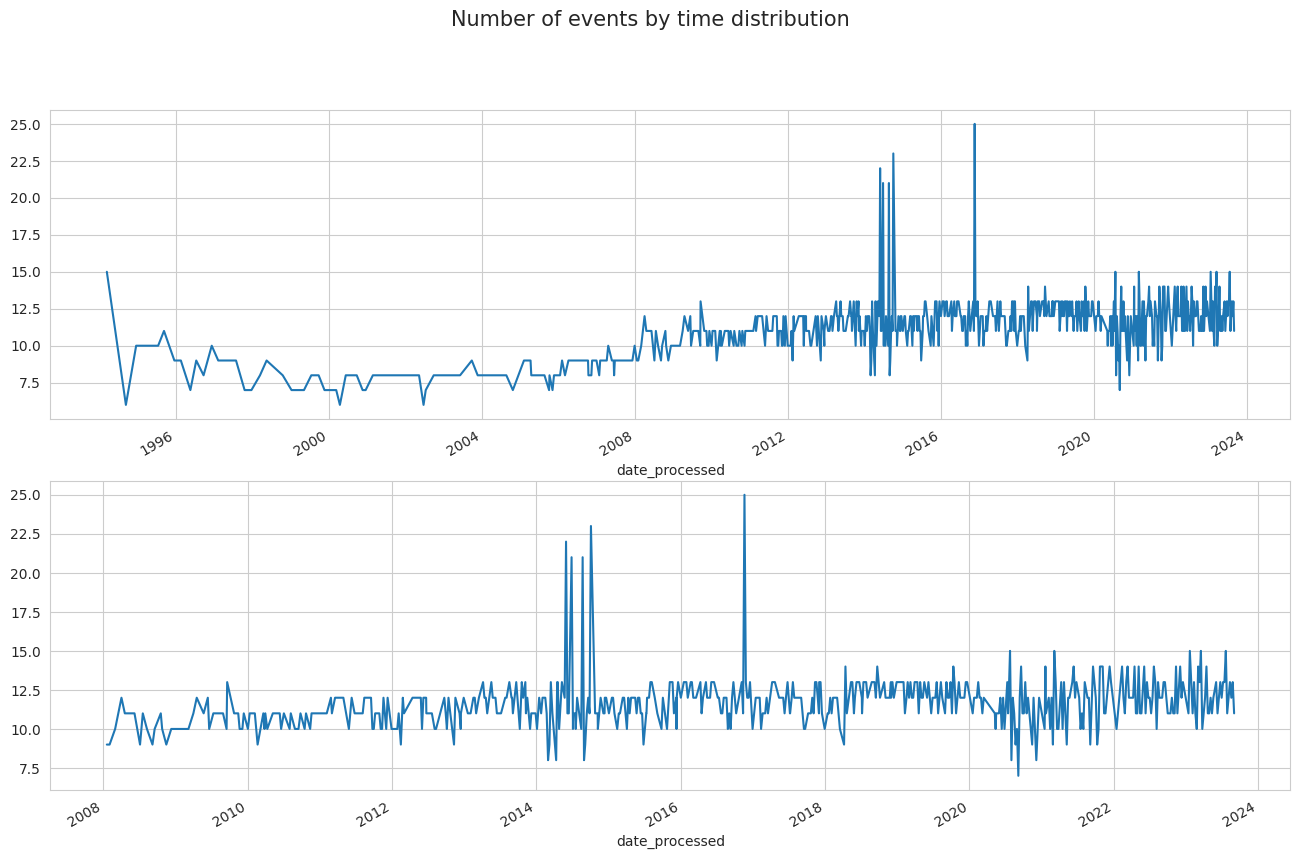

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))
fig.suptitle("Number of events by time distribution", fontsize=15);
df['date_processed'].value_counts().sort_index().plot(kind='line', ax=ax[0])
df['date_processed'][(df['date_processed'] >= datetime(2008, 1, 1))].value_counts().sort_index().plot(kind='line', ax=ax[1]);

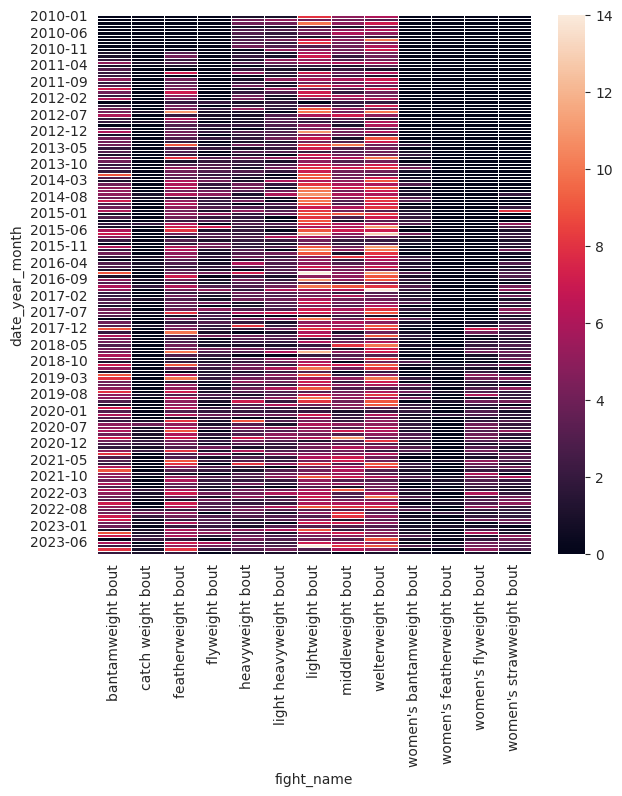

In [17]:
tmp = (
    df.loc[
        (
            df['fight_name'].apply(
                lambda x: (not x.startswith('ufc')) and (not x.startswith('ultimate')) and (not x.startswith('tuf'))
            )
        ) &
        (df['date_processed'] >= datetime(2010, 1, 1))
    ]
    .groupby('date_year_month')
    ['fight_name']
    .value_counts()
    .reset_index()
)

weights_by_month_df = pd.pivot_table(
    data=tmp,
    values='count',
    index='date_year_month',
    columns='fight_name',
    aggfunc=sum,
    fill_value=0,
)
# weights_by_month_df = weights_by_month_df/weights_by_month_df.sum(axis=1)
sns.heatmap(weights_by_month_df, lw=0.5, annot=False);

<a id='DrawingGraph'></a>
### DrawingGraph
[back to contents](#home)

In [10]:
# from ydata_profiling import ProfileReport
# report = ProfileReport(df=df)
# report.to_file(p_join(str(Path(os.getcwd()).parent), 'reports', 'raw_data_report.html'))

In [25]:
# fighter = 'Khabib Nurmagomedov'
fighter = 'Conor McGregor'
# fighter = 'Dustin Poirier'
one_fighter_stats_df = choose_fighter_stats(
    raw_fights_df=df, 
    fighter_name=fighter
)
print(f"one_fighter_stats_df: {one_fighter_stats_df.shape[0]:,}")
one_fighter_stats_df.head(3)

one_fighter_stats_df: 14


,names__1,names__2,fight_name,method,round,time,timeformat,referee,date,location,event_name,event_uri,fight_uri,winloose_fighter1,winloose_fighter2,per_round_stats__round1__fighter__1,per_round_stats__round1__fighter__2,per_round_stats__round1__kd__1,per_round_stats__round1__kd__2,per_round_stats__round1__sig_str__1,per_round_stats__round1__sig_str__2,per_round_stats__round1__sig_str_perc__1,per_round_stats__round1__sig_str_perc__2,per_round_stats__round1__totalstr__1,per_round_stats__round1__totalstr__2,per_round_stats__round1__td_perc__1,per_round_stats__round1__td_perc__2,per_round_stats__round1__sub_att__1,per_round_stats__round1__sub_att__2,per_round_stats__round1__rev__1,per_round_stats__round1__rev__2,per_round_stats__round1__ctrl__1,per_round_stats__round1__ctrl__2,per_round_stats__round1__head__1,per_round_stats__round1__head__2,per_round_stats__round1__body__1,per_round_stats__round1__body__2,per_round_stats__round1__leg__1,per_round_stats__round1__leg__2,per_round_stats__round1__distance__1,per_round_stats__round1__distance__2,per_round_stats__round1__clinch__1,per_round_stats__round1__clinch__2,per_round_stats__round1__ground__1,per_round_stats__round1__ground__2,per_round_stats__round2__fighter__1,per_round_stats__round2__fighter__2,per_round_stats__round2__kd__1,per_round_stats__round2__kd__2,per_round_stats__round2__sig_str__1,per_round_stats__round2__sig_str__2,per_round_stats__round2__sig_str_perc__1,per_round_stats__round2__sig_str_perc__2,per_round_stats__round2__totalstr__1,per_round_stats__round2__totalstr__2,per_round_stats__round2__td_perc__1,per_round_stats__round2__td_perc__2,per_round_stats__round2__sub_att__1,per_round_stats__round2__sub_att__2,per_round_stats__round2__rev__1,per_round_stats__round2__rev__2,per_round_stats__round2__ctrl__1,per_round_stats__round2__ctrl__2,per_round_stats__round2__head__1,per_round_stats__round2__head__2,per_round_stats__round2__body__1,per_round_stats__round2__body__2,per_round_stats__round2__leg__1,per_round_stats__round2__leg__2,per_round_stats__round2__distance__1,per_round_stats__round2__distance__2,per_round_stats__round2__clinch__1,per_round_stats__round2__clinch__2,per_round_stats__round2__ground__1,per_round_stats__round2__ground__2,per_round_stats__round3__fighter__1,per_round_stats__round3__fighter__2,per_round_stats__round3__kd__1,per_round_stats__round3__kd__2,per_round_stats__round3__sig_str__1,per_round_stats__round3__sig_str__2,per_round_stats__round3__sig_str_perc__1,per_round_stats__round3__sig_str_perc__2,per_round_stats__round3__totalstr__1,per_round_stats__round3__totalstr__2,per_round_stats__round3__td_perc__1,per_round_stats__round3__td_perc__2,per_round_stats__round3__sub_att__1,per_round_stats__round3__sub_att__2,per_round_stats__round3__rev__1,per_round_stats__round3__rev__2,per_round_stats__round3__ctrl__1,per_round_stats__round3__ctrl__2,per_round_stats__round3__head__1,per_round_stats__round3__head__2,per_round_stats__round3__body__1,per_round_stats__round3__body__2,per_round_stats__round3__leg__1,per_round_stats__round3__leg__2,per_round_stats__round3__distance__1,per_round_stats__round3__distance__2,per_round_stats__round3__clinch__1,per_round_stats__round3__clinch__2,per_round_stats__round3__ground__1,per_round_stats__round3__ground__2,per_round_stats__round4__fighter__1,per_round_stats__round4__fighter__2,per_round_stats__round4__kd__1,per_round_stats__round4__kd__2,per_round_stats__round4__sig_str__1,per_round_stats__round4__sig_str__2,per_round_stats__round4__sig_str_perc__1,per_round_stats__round4__sig_str_perc__2,per_round_stats__round4__totalstr__1,per_round_stats__round4__totalstr__2,per_round_stats__round4__td_perc__1,per_round_stats__round4__td_perc__2,per_round_stats__round4__sub_att__1,per_round_stats__round4__sub_att__2,per_round_stats__round4__rev__1,per_round_stats__round4__rev__2,per_round_stats__round4__ctrl__1,per_round_stats__round4__ctrl__2,per_round_stats__round4__head__1,per_round_stats__round4__head__2,per_round_st

In [26]:
from src.common_utils import get_ego_graph
fighter = 'Khabib Nurmagomedov'
# fighter = 'Conor McGregor'
# fighter = 'Dustin Poirier'

ego_graph_df = get_ego_graph(
    raw_fights_df=df,
    fighter_name=fighter
)
ego_graph_df.head(3)

,names__1,names__2,fight_name,method,round,time,timeformat,referee,date,location,event_name,event_uri,fight_uri,winloose_fighter1,winloose_fighter2,per_round_stats__round1__fighter__1,per_round_stats__round1__fighter__2,per_round_stats__round1__kd__1,per_round_stats__round1__kd__2,per_round_stats__round1__sig_str__1,per_round_stats__round1__sig_str__2,per_round_stats__round1__sig_str_perc__1,per_round_stats__round1__sig_str_perc__2,per_round_stats__round1__totalstr__1,per_round_stats__round1__totalstr__2,per_round_stats__round1__td_perc__1,per_round_stats__round1__td_perc__2,per_round_stats__round1__sub_att__1,per_round_stats__round1__sub_att__2,per_round_stats__round1__rev__1,per_round_stats__round1__rev__2,per_round_stats__round1__ctrl__1,per_round_stats__round1__ctrl__2,per_round_stats__round1__head__1,per_round_stats__round1__head__2,per_round_stats__round1__body__1,per_round_stats__round1__body__2,per_round_stats__round1__leg__1,per_round_stats__round1__leg__2,per_round_stats__round1__distance__1,per_round_stats__round1__distance__2,per_round_stats__round1__clinch__1,per_round_stats__round1__clinch__2,per_round_stats__round1__ground__1,per_round_stats__round1__ground__2,per_round_stats__round2__fighter__1,per_round_stats__round2__fighter__2,per_round_stats__round2__kd__1,per_round_stats__round2__kd__2,per_round_stats__round2__sig_str__1,per_round_stats__round2__sig_str__2,per_round_stats__round2__sig_str_perc__1,per_round_stats__round2__sig_str_perc__2,per_round_stats__round2__totalstr__1,per_round_stats__round2__totalstr__2,per_round_stats__round2__td_perc__1,per_round_stats__round2__td_perc__2,per_round_stats__round2__sub_att__1,per_round_stats__round2__sub_att__2,per_round_stats__round2__rev__1,per_round_stats__round2__rev__2,per_round_stats__round2__ctrl__1,per_round_stats__round2__ctrl__2,per_round_stats__round2__head__1,per_round_stats__round2__head__2,per_round_stats__round2__body__1,per_round_stats__round2__body__2,per_round_stats__round2__leg__1,per_round_stats__round2__leg__2,per_round_stats__round2__distance__1,per_round_stats__round2__distance__2,per_round_stats__round2__clinch__1,per_round_stats__round2__clinch__2,per_round_stats__round2__ground__1,per_round_stats__round2__ground__2,per_round_stats__round3__fighter__1,per_round_stats__round3__fighter__2,per_round_stats__round3__kd__1,per_round_stats__round3__kd__2,per_round_stats__round3__sig_str__1,per_round_stats__round3__sig_str__2,per_round_stats__round3__sig_str_perc__1,per_round_stats__round3__sig_str_perc__2,per_round_stats__round3__totalstr__1,per_round_stats__round3__totalstr__2,per_round_stats__round3__td_perc__1,per_round_stats__round3__td_perc__2,per_round_stats__round3__sub_att__1,per_round_stats__round3__sub_att__2,per_round_stats__round3__rev__1,per_round_stats__round3__rev__2,per_round_stats__round3__ctrl__1,per_round_stats__round3__ctrl__2,per_round_stats__round3__head__1,per_round_stats__round3__head__2,per_round_stats__round3__body__1,per_round_stats__round3__body__2,per_round_stats__round3__leg__1,per_round_stats__round3__leg__2,per_round_stats__round3__distance__1,per_round_stats__round3__distance__2,per_round_stats__round3__clinch__1,per_round_stats__round3__clinch__2,per_round_stats__round3__ground__1,per_round_stats__round3__ground__2,per_round_stats__round4__fighter__1,per_round_stats__round4__fighter__2,per_round_stats__round4__kd__1,per_round_stats__round4__kd__2,per_round_stats__round4__sig_str__1,per_round_stats__round4__sig_str__2,per_round_stats__round4__sig_str_perc__1,per_round_stats__round4__sig_str_perc__2,per_round_stats__round4__totalstr__1,per_round_stats__round4__totalstr__2,per_round_stats__round4__td_perc__1,per_round_stats__round4__td_perc__2,per_round_stats__round4__sub_att__1,per_round_stats__round4__sub_att__2,per_round_stats__round4__rev__1,per_round_stats__round4__rev__2,per_round_stats__round4__ctrl__1,per_round_stats__round4__ctrl__2,per_round_stats__round4__head__1,per_round_stats__round4__head__2,per_round_st

In [15]:
adjacency_dict = {}
for name1, name2, wl1, wl2 in (
    ego_graph_df[
        ['names__1', 'names__2', 'winloose_fighter1', 'winloose_fighter2']
    ].itertuples(index=False)
):
    
    name1 = name1.replace(' ', '')
    name2 = name2.replace(' ', '')
    if wl1 == wl2 == 'NC':
        continue

    if wl1 == 'W':
        assert wl2 == 'L', 'wl2 should be `L` in this case!'
        if name1 not in adjacency_dict:
            adjacency_dict[name1] = []
        if name2 not in adjacency_dict[name1]:
            adjacency_dict[name1].append(name2)
    elif wl2 == 'W':
        assert wl1 == 'L', 'wl1 should be `L` in this case!'
        if name2 not in adjacency_dict:
            adjacency_dict[name2] = []
        if name1 not in adjacency_dict[name2]:
            adjacency_dict[name2].append(name1)
adjacency_dict

{'KhabibNurmagomedov': ['JustinGaethje',
  'DustinPoirier',
  'ConorMcGregor',
  'AlIaquinta',
  'EdsonBarboza',
  'MichaelJohnson',
  'DarrellHorcher',
  'RafaelDosAnjos',
  'PatHealy',
  'AbelTrujillo',
  'ThiagoTavares',
  'GleisonTibau',
  'KamalShalorus'],
 'DoohoChoi': ['ThiagoTavares'],
 'ThiagoTavares': ['ClayGuida',
  'RobertPeralta',
  'JustinSalas',
  'SamStout',
  'SpencerFisher',
  'PatAudinwood',
  'ManvelGamburyan',
  'MichihiroOmigawa',
  'JasonBlack',
  'NaoyukiKotani'],
 'BrianOrtega': ['ThiagoTavares'],
 'ShaneRoller': ['ThiagoTavares'],
 'KurtPellegrino': ['ThiagoTavares'],
 'MattWiman': ['ThiagoTavares'],
 'TysonGriffin': ['ThiagoTavares', 'RafaelDosAnjos', 'GleisonTibau'],
 'CharlesOliveira': ['JustinGaethje', 'DustinPoirier'],
 'JustinGaethje': ['MichaelChandler',
  'TonyFerguson',
  'DonaldCerrone',
  'EdsonBarboza',
  'JamesVick',
  'MichaelJohnson',
  'RafaelFiziev'],
 'DustinPoirier': ['JustinGaethje',
  'ConorMcGregor',
  'MichaelChandler',
  'DanHooker',
  

In [33]:
json.dump(
    adjacency_dict,
    open('/home/aiandrejcev/tmp/tmp.json', mode='w', encoding='utf-8'),
    ensure_ascii=False,
    indent=2
)

In [27]:
ego_graph_df[['names__1', 'names__2']].to_csv('/home/aiandrejcev/tmp/tmp.csv', index=False)

In [28]:
G = nx.DiGraph()
G.add_edges_from(ego_graph_df[['names__1', 'names__2']].itertuples(index=False))
graph = GraphWidget()
graph.import_graph(G)
graph

GraphWidget(layout=Layout(height='500px', width='100%'))

In [29]:
graph_dict = {
    "nodes": [],
    "edges": []
}
fighters_set = set([])
for fighter1, fighter2 in ego_graph_df[['names__1', 'names__2']].itertuples(index=False):
    if fighter1 not in fighters_set:
        graph_dict['nodes'].append({
            "data": {"id": fighter1, "fighter": fighter1}
        })
        fighters_set.add(fighter1)
    if fighter2 not in fighters_set:
        graph_dict['nodes'].append({
            "data": {"id": fighter2, "fighter": fighter2}
        })
        fighters_set.add(fighter2)
    graph_dict['edges'].append({
            "data": {"source": fighter1, "target": fighter2}
        })
graph_dict

{'nodes': [{'data': {'id': 'Khabib Nurmagomedov',
    'fighter': 'Khabib Nurmagomedov'}},
  {'data': {'id': 'Justin Gaethje', 'fighter': 'Justin Gaethje'}},
  {'data': {'id': 'Dustin Poirier', 'fighter': 'Dustin Poirier'}},
  {'data': {'id': 'Conor McGregor', 'fighter': 'Conor McGregor'}},
  {'data': {'id': 'Al Iaquinta', 'fighter': 'Al Iaquinta'}},
  {'data': {'id': 'Edson Barboza', 'fighter': 'Edson Barboza'}},
  {'data': {'id': 'Michael Johnson', 'fighter': 'Michael Johnson'}},
  {'data': {'id': 'Darrell Horcher', 'fighter': 'Darrell Horcher'}},
  {'data': {'id': 'Rafael Dos Anjos', 'fighter': 'Rafael Dos Anjos'}},
  {'data': {'id': 'Pat Healy', 'fighter': 'Pat Healy'}},
  {'data': {'id': 'Abel Trujillo', 'fighter': 'Abel Trujillo'}},
  {'data': {'id': 'Thiago Tavares', 'fighter': 'Thiago Tavares'}},
  {'data': {'id': 'Gleison Tibau', 'fighter': 'Gleison Tibau'}},
  {'data': {'id': 'Kamal Shalorus', 'fighter': 'Kamal Shalorus'}},
  {'data': {'id': 'Roosevelt Roberts', 'fighter': 'Ro

In [18]:
json.dump(
    graph_dict,
    open('/home/aiandrejcev/tmp/graph_dict.json', mode='w', encoding='utf-8'),
    ensure_ascii=False,
    indent=2
)

In [30]:
from yfiles_jupyter_graphs import GraphWidget
w = GraphWidget()
w.nodes = [
    {"id": 0, "properties": {"firstName": "Alpha", "label": "Person A"}},
    {"id": "one", "properties": {"firstName": "Bravo", "label": "Person B"}},
    {"id": 2.0, "properties": {"firstName": "Charlie", "label": "Person C", "has_hat": False}},
    {"id": True, "properties": {"firstName": "Delta", "label": "Person D", "likes_pizza": True}}
]
w.edges = [
    {"id": "zero", "start": 0, "end": "one", "properties": {"since": "1992", "label": "knows"}},
    {"id": 1, "start": "one", "end": True, "properties": {"label": "knows", "since": "1992"}},
    {"id": 2.0, "start": 2.0, "end": True, "properties": {"label": "knows", "since": "1992"}},
    {"id": False, "start": 0, "end": 2.0, "properties": {"label": "knows", "since": 234}}
]
w.directed = True
w.show() 

GraphWidget(layout=Layout(height='500px', width='100%'))

In [105]:
style = [
    {
        "selector": 'core',
        "style": {
            "selection-box-color": '#000',
        }
    },
    {
        'selector': 'node',
        'style': {
            'font-family': 'arial',
            'font-size': '6px',
            "text-valign": "center",
            "text-halign": "center",
            'text-background-color': '#77828',
            "text-border-color": 'red',
            'label': 'data(fighter)',
            'background-color': 'blue'
        }
    },
    {
        'selector': 'edge',
        'style': {
            'curve-style': 'haystack',
            'haystack-radius': '0.5',
            'opacity': '0.4',
            'line-color': '#bbb',
            'width': '2',
            'overlay-padding': '3px'
        }
    }
]

In [106]:
directed = CytoscapeWidget()
directed.graph.add_graph_from_json(graph_dict, directed=True)
directed.set_layout(name='cose', nodeSpacing=40, edgeLengthVal=1000)
directed.set_style(style)
directed

CytoscapeWidget(cytoscape_layout={'name': 'cose', 'nodeSpacing': 40, 'edgeLengthVal': 1000}, cytoscape_style=[…

In [ ]:
G = nx.complete_graph(5)
undirected = CytoscapeWidget()
undirected.graph.add_graph_from_networkx(G)
display(undirected)

In [ ]:
G2 = nx.Graph()
G2.add_node('separate node 1')
G2.add_node('separate node 2')
G2.add_edge('separate node 1', 'separate node 2')
undirected.graph.add_graph_from_networkx(G2)

In [ ]:
G = nx.complete_graph(5)
directed = ipycytoscape.CytoscapeWidget()
directed.graph.add_graph_from_networkx(G, directed=True)
directed


In [ ]:
data = {
    'nodes': [
        { 'data': { 'id': 'desktop', 'name': 'Cytoscape', 'href': 'http://cytoscape.org' } },
        { 'data': { 'id': 'a', 'name': 'Grid', 'href': 'http://cytoscape.org' } },
        { 'data': { 'id': 'b', 'name': 'Cola', 'href': 'http://cytoscape.org' } },
        { 'data': { 'id': 'c', 'name': 'Popper', 'href': 'http://cytoscape.org' } },
        { 'data': { 'id': 'js', 'name': 'Cytoscape.js', 'href': 'http://js.cytoscape.org' } }
    ],
    'edges': [
        {'data': { 'source': 'desktop', 'target': 'js' }},
        {'data': { 'source': 'a', 'target': 'b' }},
        {'data': { 'source': 'a', 'target': 'c' }},
        {'data': { 'source': 'b', 'target': 'c' }},
        {'data': { 'source': 'js', 'target': 'b' }}
    ]
}
cytoscapeobj = CytoscapeWidget()
cytoscapeobj.graph.add_graph_from_json(data, directed=True)
cytoscapeobj.set_style([{
                        'selector': 'node',
                        'css': {
                            'content': 'data(name)',
                            'text-valign': 'center',
                            'color': 'white',
                            'text-outline-width': 2,
                            'text-outline-color': 'black',
                            'background-color': 'blue'
                        }
                        },
                        {
                        'selector': ':selected',
                        'css': {
                            'background-color': 'black',
                            'line-color': 'black',
                            'target-arrow-color': 'black',
                            'source-arrow-color': 'black',
                            'text-outline-color': 'black'
                        }}
                        ])
cytoscapeobj

In [26]:
railnet= '''{
    "nodes": [
        {"data": { "id": "BER" }},
        {"data": { "id": "MUN"}},
        {"data": { "id": "FRA"}},
        {"data": { "id": "HAM"}}
        ],
    "edges": [
        {"data": { "source": "BER", "target": "MUN" }},
        {"data": { "source": "MUN", "target": "FRA" }},
        {"data": { "source": "FRA", "target": "BER" }},
        {"data": { "source": "BER", "target": "HAM" }}
        
    ]
  }'''
print(type(railnet))
railnetJSON = json.loads(railnet)

<class 'str'>


In [28]:
tmp = ipycytoscape.CytoscapeWidget()

In [29]:
tmp.graph.add_graph_from_json(railnetJSON)
tmp

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'background-c…

In [30]:
ipycytoscape_obj2 = ipycytoscape.CytoscapeWidget()
ipycytoscape_obj2.graph.add_graph_from_json(railnetJSON, directed=True) # I am telling I dont want directions
ipycytoscape_obj2

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'background-c…

In [32]:
railnet= '''{
    "nodes": [
        {"data": { "id": "BER", "label":"HBf BER"}},
        {"data": { "id": "MUN", "label":"HBf MUN"}},
        {"data": { "id": "FRA", "label":"HBf FRA"}},
        {"data": { "id": "HAM", "label":"HBf HAM"}}
        ],
    "edges": [
        {"data": { "source": "BER", "target": "MUN" }},
        {"data": { "source": "MUN", "target": "FRA" }},
        {"data": { "source": "FRA", "target": "BER" }},
        {"data": { "source": "BER", "target": "HAM" }}
        
    ]
  }'''

my_style = [
    {'selector': 'node','style': {
        'font-family': 'helvetica',
        'font-size': '20px',
        'label': 'data(label)'}},
    ]

railnetJSON = json.loads(railnet)
ipycytoscape_obj4 = ipycytoscape.CytoscapeWidget()
ipycytoscape_obj4.graph.add_graph_from_json(railnetJSON, directed=False) # I am telling I dont want directions
ipycytoscape_obj4.set_style(my_style)
ipycytoscape_obj4

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'style': {'font-famil…

In [33]:
my_style = [
    {'selector': 'node','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)',
        'background-color': 'red'}},
    
    {'selector': 'node[id = "BER"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)',
        'background-color': 'green'}}
    
    ]
ipycytoscape_obj7 = ipycytoscape.CytoscapeWidget()
ipycytoscape_obj7.graph.add_graph_from_json(railnetJSON, directed=False) # I am telling I dont want directions
ipycytoscape_obj7.set_style(my_style)
ipycytoscape_obj7.set_style(my_style)
ipycytoscape_obj7

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'style': {'font-famil…

In [34]:
railnet= '''{
    "nodes": [
        {"data": { "id": "BER", "label":"HBf BER"}},
        {"data": { "id": "MUN", "label":"HBf MUN"}},
        {"data": { "id": "FRA", "label":"HBf FRA"}},
        {"data": { "id": "HAM", "label":"HBf HAM"}}
        ],
    "edges": [
        {"data": { "id": "line1", "source": "BER", "target": "MUN","label":"200km/h"}},
        {"data": { "id": "line2", "source": "MUN", "target": "FRA","label":"200km/h"}},
        {"data": { "id": "line3", "source": "FRA", "target": "BER","label":"250km/h" }},
        {"data": { "id": "line4", "source": "BER", "target": "HAM","label":"300km/h" }}
        
    ]
  }'''

my_style = [
    {'selector': 'node','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)',
        'background-color': 'red'}},
    
    {'selector': 'node[id = "BER"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)',
        'background-color': 'green'}},
    
    {'selector': 'edge[id = "line1"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)',}},
    
    {'selector': 'edge[id = "line2"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)',}},
    
    {'selector': 'edge[id = "line3"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)',}},
    
    {'selector': 'edge[id = "line4"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)',}}
    
    ]
railnetJSON = json.loads(railnet)
ipycytoscape_obj8 = ipycytoscape.CytoscapeWidget()
ipycytoscape_obj8.graph.add_graph_from_json(railnetJSON, directed=True) # We're specifying that the graph should be undirected
ipycytoscape_obj8.set_style(my_style)
ipycytoscape_obj8.set_style(my_style)
ipycytoscape_obj8

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'style': {'font-famil…

In [36]:
railnet= '''{
    "nodes": [
        {"data": { "id": "BER", "label":"HBf BER"}, "classes":"east"},
        {"data": { "id": "MUN", "label":"HBf MUN"}, "classes":"west"},
        {"data": { "id": "FRA", "label":"HBf FRA"}, "classes":"west"},
        {"data": { "id": "HAM", "label":"HBf HAM"}, "classes":"west"},
        {"data": { "id": "LEP", "label":"HBf LEP"}, "classes":"east"}
        ],
    "edges": [
        {"data": { "id": "line1", "source": "BER", "target": "MUN","label":"200km/h"}},
        {"data": { "id": "line2", "source": "MUN", "target": "FRA","label":"200km/h"}},
        {"data": { "id": "line3", "source": "FRA", "target": "BER","label":"250km/h" }},
        {"data": { "id": "line4", "source": "BER", "target": "HAM","label":"300km/h" }},
        {"data": { "id": "line5", "source": "BER", "target": "LEP","label":"300km/h" }}
        
    ]
  }'''

my_style = [
    {'selector': 'node','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)',}},
    
    {'selector': 'node.east','style': {
        'background-color': 'yellow'}},
    
     {'selector': 'node.west','style': {
        'background-color': 'blue'}},
    
    
    {'selector': 'node[id = "BER"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)',
        'background-color': 'orange'}},
    
    {'selector': 'edge[id = "line1"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)'}},
    
    {'selector': 'edge[id = "line2"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)'}},
    
    {'selector': 'edge[id = "line3"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)'}},
    
    {'selector': 'edge[id = "line4"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)'}},
    
    {'selector': 'edge[id = "line5"]','style': {
        'font-family': 'arial',
        'font-size': '10px',
        'label': 'data(label)'}}
    
    ]
railnetJSON = json.loads(railnet)
ipycytoscape_obj9 = ipycytoscape.CytoscapeWidget()
ipycytoscape_obj9.graph.add_graph_from_json(railnetJSON, directed=True) # We're specifying that the graph should be undirected
ipycytoscape_obj9.set_style(my_style)
ipycytoscape_obj9

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'style': {'font-famil…

In [9]:
from networkx import connected_caveman_graph
from yfiles_jupyter_graphs import GraphWidget
w = GraphWidget()

In [18]:
w.import_graph(G)
w

GraphWidget(layout=Layout(height='500px', width='100%'))